In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import utils
import torch
import random
import mlflow
import dotenv
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from model import NeuMF
from dataset import RatingDataset
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
TRACKING_URL = "http://175.41.182.223:5050/"
EXPERIMENT_NAME ="movielens-rating-recommender"

In [5]:
dotenv.load_dotenv("./.env")

True

## (1) Load Artifacts

In [6]:
use_id_map_pkl_file = "./artifacts/user_id_map_dict.pkl"
user_id_map_dict = utils.open_object(use_id_map_pkl_file)

movie_id_map_pkl_file = "./artifacts/movie_id_map_dict.pkl"
movie_id_map_dict = utils.open_object(movie_id_map_pkl_file)


genres_map_pkl_file = "./artifacts/genres_map_dict.pkl"
genres_map_dict = utils.open_object(genres_map_pkl_file)


In [7]:
num_user = len(user_id_map_dict)
num_movie = len(movie_id_map_dict)
num_genre = len(genres_map_dict)

## (2) Parameter

In [8]:
config_dict={}
config_dict['num_user'] = num_user 
config_dict['num_item'] = num_movie 
config_dict['num_genre'] = num_genre
config_dict['latent_dim_mlp'] =  128
config_dict['latent_dim_mf']=config_dict['latent_dim_mlp']
config_dict['layers'] = [config_dict['latent_dim_mf']*2]+[64,32]
config_dict['num_layers'] = len(config_dict['layers'])
config_dict['dropout_rate_mf']=0.6
config_dict['dropout_rate_mlp']=0.6
config_dict['batch_size']=32
config_dict['epoches']=8
config_dict['eval_steps']=500
config_dict['use_xavier_uniform']=False
config_dict['learning_rate']=0.001

In [9]:
config_dict

{'num_user': 611,
 'num_item': 9725,
 'num_genre': 21,
 'latent_dim_mlp': 128,
 'latent_dim_mf': 128,
 'layers': [256, 64, 32],
 'num_layers': 3,
 'dropout_rate_mf': 0.6,
 'dropout_rate_mlp': 0.6,
 'batch_size': 32,
 'epoches': 8,
 'eval_steps': 500,
 'use_xavier_uniform': False,
 'learning_rate': 0.001}

In [10]:
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

## (3) Build Model

In [11]:
config = Config(dictionary=config_dict)

In [12]:
model = NeuMF(config=config)

## (4) Load Data

In [13]:
df_train = pd.read_parquet("./data/train.parquet")
df_test = pd.read_parquet("./data/test.parquet")

In [14]:
train_dataset = RatingDataset(data=df_train)
test_dataset = RatingDataset(data=df_test)

In [15]:
train_dataset[:10]

{'user_embed_id': tensor([ 64, 141, 385, 182,  73,  63, 504,   9,  23, 309]),
 'movie_embed_id': tensor([1887,  876,   72,   90, 3541,  181,  429,   71, 2070, 2050]),
 'rating': tensor([0.6000, 0.9000, 1.0000, 0.7000, 0.4000, 1.0000, 0.8000, 1.0000, 0.6000,
         0.8000])}

In [16]:
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=True)

In [17]:
for sample in train_loader:
    break

In [18]:
with torch.no_grad():
    outputs = model(
        user_indices=sample['user_embed_id'],
        item_indices=sample['movie_embed_id'])

In [19]:
loss_func = torch.nn.BCELoss()
loss = loss_func(outputs, sample['rating'].view(-1, 1))
print(loss)

tensor(0.7396)


In [20]:
metrics.mean_squared_error(outputs.numpy().flatten(),
                           sample['rating'].numpy())

0.10633895

## (5) Trainning

#### Before Training

In [21]:
from evaluation import evaluate

In [22]:
evaluate(model,test_loader)

100%|██████████| 316/316 [00:00<00:00, 676.61it/s]


{'eval_loss': 0.7721418891149231, 'eval_mse': 0.11518298201257628}

In [23]:
optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)

In [24]:
total_batch = 0
best_eval_loss =  float("inf")
best_checkpoint = 0

In [25]:
from utils import save_model
model_version='v1'

In [26]:
# Train
total_pbar = tqdm(total=len(train_loader)*config.epoches,
                  desc="Training", position=0, leave=True)

metrics_list = []

mlflow.set_tracking_uri(TRACKING_URL)
mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run():
    mlflow.set_tag("algorithm",'neural-cf')
    mlflow.log_params(config_dict)
    mlflow.log_artifact("./model.py", artifact_path="model")
#     mlflow.log_artifact(movie_id_map_pkl_file, artifact_path="artifacts")
#     mlflow.log_artifact(genres_map_pkl_file, artifact_path="artifacts")

    for epoch in range(config.epoches):
        # print("*"*50 + f"epoch: {epoch + 1}" + "*"*50)

        train_loss_list = []
        prob_list = []
        rating_list = []

        for inputs in train_loader:
            model = model.train()
            optimizer.zero_grad()
            probs = model(
                user_indices=inputs['user_embed_id'],
                item_indices=inputs['movie_embed_id']
            )
            rating = inputs['rating'].view(-1, 1)

            loss = loss_func(probs, rating)
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())

            probs = probs.detach().cpu().numpy().flatten().tolist()
            prob_list.extend(probs)
            rating = rating.numpy().flatten().tolist()
            rating_list.extend(rating)

            if (total_batch+1) % config.eval_steps == 0:

                improve = False
                model_metrics = evaluate(model, test_loader)
                eval_loss = model_metrics['eval_loss']

                if eval_loss <= best_eval_loss:
                    improve = True
                    best_checkpoint = total_batch+1
                    best_eval_loss = eval_loss

                train_loss = np.mean(train_loss_list)
                
                model_metrics['best_eval_loss'] = best_eval_loss
                model_metrics['train_loss'] = train_loss
                model_metrics['train_mse'] = metrics.mean_squared_error(
                    rating_list, prob_list)
                model_metrics["steps"] = total_batch+1
                model_metrics["best_checkpoint"] = best_checkpoint
                metrics_list.append(model_metrics)
                for metrics_name,metrics_value in model_metrics.items():
                    mlflow.log_metric(metrics_name,metrics_value)
                    
                if improve:
                    save_dir = os.path.join("model", model_version)
                    os.makedirs(save_dir, exist_ok=True)
                    model_path = save_model(model, save_dir, total_batch+1, model_metrics)
                    mlflow.log_artifact(model_path, artifact_path="model")
                
                post_fix_message = {k:round(v,3) for k,v in model_metrics.items()}
                total_pbar.set_postfix(post_fix_message)

                # df_metrics_temp = pd.DataFrame([model_metrics])
                # display(df_metrics_temp)

                model = model.train()

            total_batch += 1
            total_pbar.update(1)

        model = model.train()

    total_pbar.close()

Training: 100%|██████████| 22688/22688 [04:25<00:00, 85.34it/s, eval_loss=0.591, eval_mse=0.034, best_eval_loss=0.587, train_loss=0.562, train_mse=0.023, steps=22500, best_checkpoint=12000] 


In [27]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics

,eval_loss,eval_mse,best_eval_loss,train_loss,train_mse,steps,best_checkpoint
0,0.607049,0.041334,0.607049,0.623090,0.048920,500,500
1,0.601055,0.039036,0.601055,0.612187,0.044275,1000,1000
2,0.597812,0.037690,0.597812,0.607277,0.041882,1500,1500
3,0.598087,0.037656,0.597812,0.604019,0.040526,2000,1500
4,0.594354,0.036315,0.594354,0.601812,0.039518,2500,2500
5,0.593017,0.035620,0.593017,0.582425,0.033136,3000,3000
6,0.592337,0.035283,0.592337,0.584995,0.032813,3500,3500
7,0.590888,0.034719,0.590888,0.585661,0.032847,4000,4000
8,0.591617,0.035126,0.590888,0.585167,0.032778,4500,4000
9,0.589978,0.034418,0.589978,0.584795,0.032581,5000,5000


In [28]:
df_metrics = df_metrics.set_index("steps")

<Axes: xlabel='steps'>

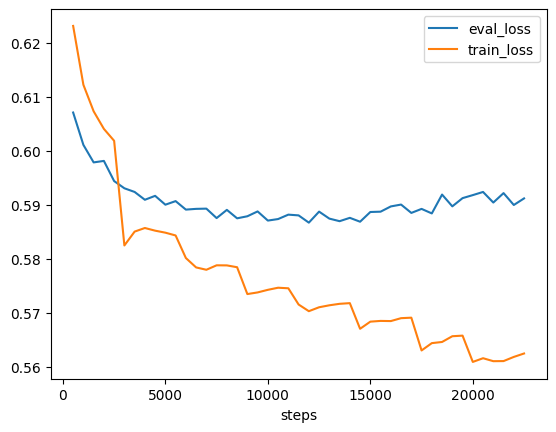

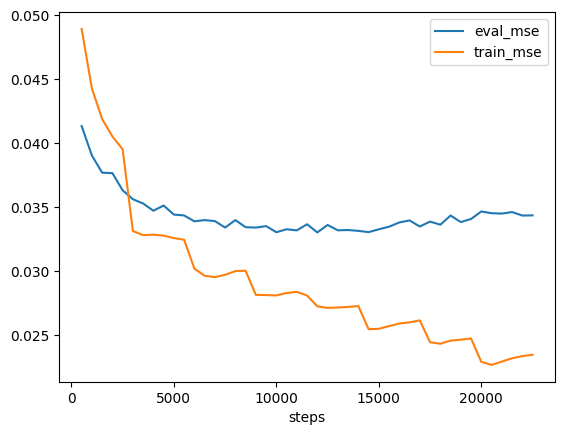

In [29]:
# fig, ax = plt.subplots(figsize=(20,10)) 
df_metrics[['eval_loss','train_loss']].plot() 
df_metrics[['eval_mse','train_mse']].plot() 
# df.plot(x = 'day', y = 'humidity', ax = ax, secondary_y = True) 